In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools

np.random.seed(2)

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

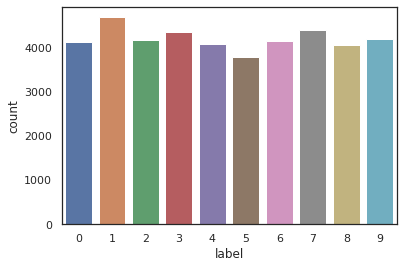

In [89]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

Y_train = train['label']
X_train = train.drop(labels=['label'], axis = 1)

del train 

sns.countplot(Y_train)

In [0]:
X_train = X_train / 255.
test = test / 255.

X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Y_train = to_categorical(Y_train, num_classes = 10)

random_seed = 2

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

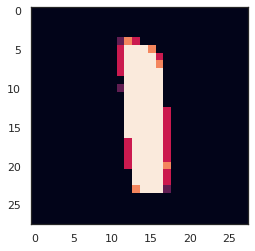

In [92]:
plt.imshow(X_train[76][:,:,0])

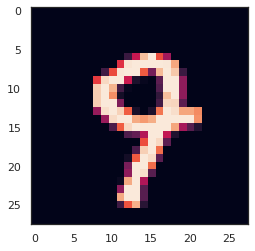

In [93]:
plt.imshow(X_val[1][:,:,0])

In [0]:
model = Sequential([
                    Conv2D(32, (5,5), padding = 'same', activation = 'relu', input_shape = (28,28,1)),
                    Conv2D(32, (5,5), padding = 'same', activation = 'relu'),
                    MaxPool2D(pool_size = (2,2)),
                    Dropout(0.25),
                    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
                    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
                    MaxPool2D(pool_size = (2,2), strides = (2,2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dropout(0.5),
                    Dense(10, activation = 'softmax')
    ])

In [0]:
opt = RMSprop(lr=0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            factor = 0.5,
                                            patience = 3,
                                            verbose = 1, 
                                            min_lr = 0.00001)


In [97]:
epochs = 2
batch_size = 86
step = X_train.shape[0] // batch_size

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1)
datagen.fit(X_train)

histoy = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                             epochs = epochs,
                             validation_data = (X_val, Y_val),
                             steps_per_epoch = step,
                             verbose = 2,
                             callbacks = [learning_rate_reduction]
                             )

Epoch 1/2
 - 272s - loss: 0.4177 - accuracy: 0.8642 - val_loss: 0.0734 - val_accuracy: 0.9745
Epoch 2/2
 - 267s - loss: 0.1267 - accuracy: 0.9622 - val_loss: 0.0416 - val_accuracy: 0.9879


In [0]:
results = model.predict(test)
results = np.argmax(results, axis =1)
results = pd.Series(results, name = 'Label')

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv", index=False)